In [1]:
%matplotlib notebook

# import the required packages
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
#import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import torch.utils.data as data
import copy

from torchmetrics import F1Score
from torchmetrics.functional import auroc
from torchmetrics.functional import precision_recall
from torchmetrics import AUROC

In [2]:
#first put a shortcut in your drive to the image processing folder

RESULTS_DIR = os.path.join('/home',
                        'emily',
                        'Desktop',
                        'CAD',
                        'results',
                        'model')


DATA_DIR = os.path.join('/home',
                        'emily',
                        'Desktop',
                        'CAD',
                        'challenge1')

#print(os.listdir(RESULTS_DIR))

data_file = os.listdir(RESULTS_DIR)

In [3]:
# hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 20
momentum = 0.9
lr_step_size = 7   # if < epochs, we are using decaying learning rate
lr_gamma = 0.1
data_augmentation = True
dropout = 0.1
activation = nn.LeakyReLU()

# make visible only one GPU at the time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # <-- should be the ID of the GPU you want to use

# options
# device = "cuda:0"           # put here "cuda:0" if you want to run on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
monitor_display = True      # whether to display monitored performance plots
display_first_n = 0         # how many samples/batches are displayed
num_workers = 2             # how many workers (=threads) for fetching data
pretrained = False          # whether to test a pretrained model (to be loaded) or train a new one
display_errors = True       # whether to display errors (only in pretrained mode)
print(torch.cuda.is_available())

True


In [4]:
import torchvision.transforms.functional as TF
import random

random.seed(1)
# We need to use numpy for rotation transformation
# For sigma and mean we nee to do patch wise

# https://arxiv.org/pdf/2010.05351v1.pdf
class MyRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, times, mode):
        self.times = times
        self.mode = mode

    def __call__(self, x):
        mode = random.choice(self.mode)
        if mode == 0:
          return np.fliplr(x)
        elif mode == 1:
          return np.flipud(x)
        else:   
          times = random.choice(self.times)
          return np.rot90(x, times)
# -90, 0, 90, and 180 degrees rotation

#rotation_transform = MyRotationTransform(angles=[-90, 0, 90, 180])
# pytorch transformations for augmentation https://arxiv.org/pdf/2010.05351v1.pdf
# DataAugmentation = transforms.RandomApply(
#         [ np.RandomHorizontalFlip(), 
#      transforms.RandomVerticalFlip(),
#      #transforms.RandomRotation(90, fill=(0,)),
#       MyRotationTransform(times=[1,2,3])] , p=0.5)  # fill=(0,) is a workaround for the torchvision bug tracked at https://github.com/pytorch/vision/issues/1759#issuecomment-575307516

class Convert(object):
    def __call__(self, img):
        return torch.unsqueeze(torch.from_numpy(img.astype('float')), 0).float()

transform_train = transforms.Compose(
    [MyRotationTransform(times=[1,2,3], mode=[0,1,2,3])]) 

# should randomly apply a transformation from the list

**Load information**

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}    


image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

    
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

val_labels =torch.Tensor([])
for batch in dataloaders['val']:
    val_labels = torch.cat((val_labels, batch[1]), 0)
#print(val_labels)

train_labels = torch.Tensor([])
for batch in dataloaders['train']:
    train_labels = torch.cat((train_labels, batch[1]), 0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    #plt.figure(figsize = (6,6))
    plt.imshow(inp)
    #print(os.path.join(RESULTS_DIR, str(title[0])) + ".png")
    plt.savefig(os.path.join(RESULTS_DIR, str(title)) + ".png", dpi=300)
    if title is not None:
        plt.title(str(title))
    plt.pause(0.001)  # pause a bit so that plots are updated
    

In [7]:
# Get a batch of training data
batch = next(iter(dataloaders['train']))
inputs = batch[0]
classes = batch[1]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#imshow(out, title=[x.item() for x in classes])

**Dataloader**

In [8]:
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

### **Model definition**

In [9]:
#from torchsummary import summary

import torchvision.models as models

NUM_CLASSES = 2

#Inception_V3_Weights.IMAGENET1K_V1

# pretrained efficient net b3
# https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b3.html#torchvision.models.efficientnet_b3
mobilenetv3 = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2)

# https://stackoverflow.com/questions/68047331/how-to-add-the-last-classification-layer-in-efficienet-pre-trained-model-in-pyto
# efficientnet._fc = torch.nn.Linear(in_features = efficientb3._fc.in_features,
#                                   out_features = NUM_CLASSES,
#                                   bias = TRUE)

mobilenetv3.classifier[3] = torch.nn.Linear( in_features = mobilenetv3.classifier[3].in_features,
                                          out_features = NUM_CLASSES,
                                          bias = True)
print(mobilenetv3)
#efficientb3.fc = nn.Linear(2048,2)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

**Useful Metrics and Functions**

In [10]:
def confusion(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

In [11]:
def save(model, path_to_save: str) -> None:
    torch.save(model.state_dict(), path_to_save)

def load(model, path_to_model: str):
    return model.load_state_dict(torch.load(path_to_model))

In [12]:
# define train function (1 epoch)
# returns average loss and accuracy
def train(dataset_size, net, scheduler, device, optimizer, criterion, dataloader):

    # switch to train mode
    net.train()

    # step learning rate scheduler
    scheduler.step()

    # reset performance measures
    loss_sum = 0.0
    correct = 0

    # 1 epoch = 1 complete loop over the dataset
    for batch in dataloader:

        # get data from dataloader
        inputs, targets = batch

        # move data to device
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = net(inputs)

        # calculate loss
        loss = criterion(outputs, targets)

        # loss gradient backpropagation
        loss.backward()

        # net parameters update
        optimizer.step()

        # accumulate loss
        loss_sum += loss.item()

        # accumulate correct outputs (for accuracy calculation)
        outputs_max = outputs.argmax(dim=1)
        correct += outputs_max.eq(targets).sum().float().item()

    # return average loss and accuracy        
    avg_loss = loss_sum / len(dataloader)
    accuracy_train = 100. * correct / dataset_size
    return avg_loss, accuracy_train

In [13]:
# define test function
# returns predictions
def test(dataset_size, net, dataloader, criterion):

    # switch to test mode
    net.eval()  

    # initialize predictions 
    predictions = torch.zeros(dataset_size, dtype=torch.int64)
    sample_counter = 0

    loss_sum = 0.0
    correct = 0
    
    # do not accumulate gradients (faster)
    with torch.no_grad():

        # test all batches
        for inputs, targets in dataloader:

            # move data to device
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)

            # forward pass
            outputs = net(inputs)
            
            # calculate loss
            valid_loss = criterion(outputs, targets)
            
            # accumulate loss
            loss_sum += valid_loss.item()
            
            # accumulate correct outputs (for accuracy calculation)
            outputs_max = outputs.argmax(dim=1)
            correct += outputs_max.eq(targets).sum().float().item()

    # return average loss and accuracy        
    avg_loss = loss_sum / len(dataloader)
    accuracy_valid = 100. * correct / dataset_size
    
    return avg_loss, accuracy_valid

**Train and test function**

In [14]:
def train_model(model, val_labels, dataloader, criterion, optimizer, scheduler, model_name, num_epochs=30, load_trained=False):
    
    f1 = F1Score(num_classes=2).to(device)

    if load_trained:
      checkpoint = torch.load(os.path.join(RESULTS_DIR, model_name))
      model.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      last_epoch = checkpoint['epoch']+1
      loss = checkpoint['loss']

    else:
      last_epoch=0

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    ticks = []

    best_model_wts = copy.deepcopy(model.state_dict()) #It keeps track of the parameters of the model in certain state
    best_auc = 0.0
  
    for epoch in range(last_epoch, num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        # measure time elapsed
        t0 = time.time()
        
        # start time
        since = time.time()

        # train
        avg_loss, accuracy_train = train(dataset_sizes['train'], net, scheduler, device, optimizer, criterion, dataloader['train'])
        
        # test on validation
        # to check
        valid_loss, accuracy_valid = test(dataset_sizes['val'], net, dataloader['val'], criterion)
        
        
        # update performance historyw
        train_losses.append(avg_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(accuracy_train)
        valid_accuracies.append(accuracy_valid)
        ticks.append(epoch)
        
        running_loss = 0.0
    #            running_corrects = 0
    
        
        print ( "...TIME: {:.2f} seconds\n"
                "...train loss: {:.2f} (best {:.2f} at epoch {})\n"
                "...validation loss: {:.2f} (best {:.2f} at epoch {})\n"
                "...training accuracy: {:.2f} (best {:.2f} at epoch {})\n"
                "...validation accuracy: {:.2f} (best {:.2f} at epoch {})".format(
                time.time()-t0,
                avg_loss, min(train_losses), ticks[np.argmin(train_losses)],
                valid_loss, min(valid_losses), ticks[np.argmin(valid_loss)],
                accuracy_train, max(train_accuracies), ticks[np.argmax(train_accuracies)],
                accuracy_valid, max(valid_accuracies), ticks[np.argmax(valid_accuracies)]))

        # plot
        fig, ax1 = plt.subplots(figsize=(12,8), num=1)
        ax1.set_xticks(np.arange(0, epochs+1, step=epochs/10.0))
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel(type(criterion).__name__, color='blue')
        ax1.set_ylim(0.0001, 10)
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.set_yscale('log')
        ax1.plot(ticks, train_losses, 'b-', linewidth=1.0, aa=True, 
            label='Training {:.2f} ( best {:.2f} at ep. {})'.format(avg_loss, min(train_losses), ticks[np.argmin(train_losses)]))
        ax1.plot(ticks, valid_losses, 'b--', linewidth=1.0, aa=True,
                 label='Validation {:.2f} ( best {:.2f} at ep. {})'.format(valid_loss, min(valid_losses), ticks[np.argmin(valid_losses)]))
        ax1.legend(loc="lower left")
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('Accuracy %', color='red')
        ax2.set_ylim(50, 100)
        ax2.set_yticks(np.arange(50, 100, step=10))
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.plot(ticks, train_accuracies, 'r-', linewidth=1.0, aa=True, 
            label='Training {:.2f}%  ( best {:.2f}% at ep. {})'.format(accuracy_train, max(train_accuracies), ticks[np.argmax(train_accuracies)]))
        ax2.plot(ticks, valid_accuracies, 'r--', linewidth=1.0, aa=True, 
            label='Validation {:.2f}% ( best {:.2f}% at ep. {})'.format(accuracy_valid, max(valid_accuracies), ticks[np.argmax(valid_accuracies)]))
        ax2.legend(loc="lower right")
        plt.xlim(0, epochs+1)
        # this works if running from notebooks
        if True:
            fig.show()
            fig.canvas.draw()
        # this works if running from console
        else:
            plt.draw()
            plt.pause(0.001)
        plt.savefig(os.path.join(RESULTS_DIR, experiment_ID) + ".png", dpi=300)
        fig.clear()


        # deep copy the model if the performance improve
        #if phase == 'val' and epoch_auc > best_auc:
        #    best_auc = epoch_auc
        #    best_model_wts = copy.deepcopy(model.state_dict())

        if (epoch-1) == np.argmax(valid_accuracies):
            
            scheduler.step()
            
            torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            }, os.path.join(RESULTS_DIR, model_name))  
            
            best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val auc: {:4f}'.format(best_auc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**Model initialization and Training**

In [15]:
net = mobilenetv3.to(device) #we need to also send the model to the GPU as well

# create loss function
criterion = nn.CrossEntropyLoss() #most used for classification purposes

# create SGD optimizer
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum) #most common optimizer is adam

# create learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

# experiment ID
experiment_ID = "try_%s_%s_%s_bs(%d)lr(%.4f_%d_%.1f)m(%.1f)e(%d)act(%s)xavier(yes)da(%s)do(%.1f)BN" % (type(net).__name__, type(criterion).__name__, type(optimizer).__name__,
                batch_size, learning_rate, lr_step_size, lr_gamma, momentum, epochs, type(activation).__name__, data_augmentation, dropout)

Epoch 1/20
----------


/home/emily/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


...TIME: 117.56 seconds
...train loss: 0.47 (best 0.47 at epoch 0)
...validation loss: 0.43 (best 0.43 at epoch 0)
...training accuracy: 77.60 (best 77.60 at epoch 0)
...validation accuracy: 78.64 (best 78.64 at epoch 0)


<IPython.core.display.Javascript object>


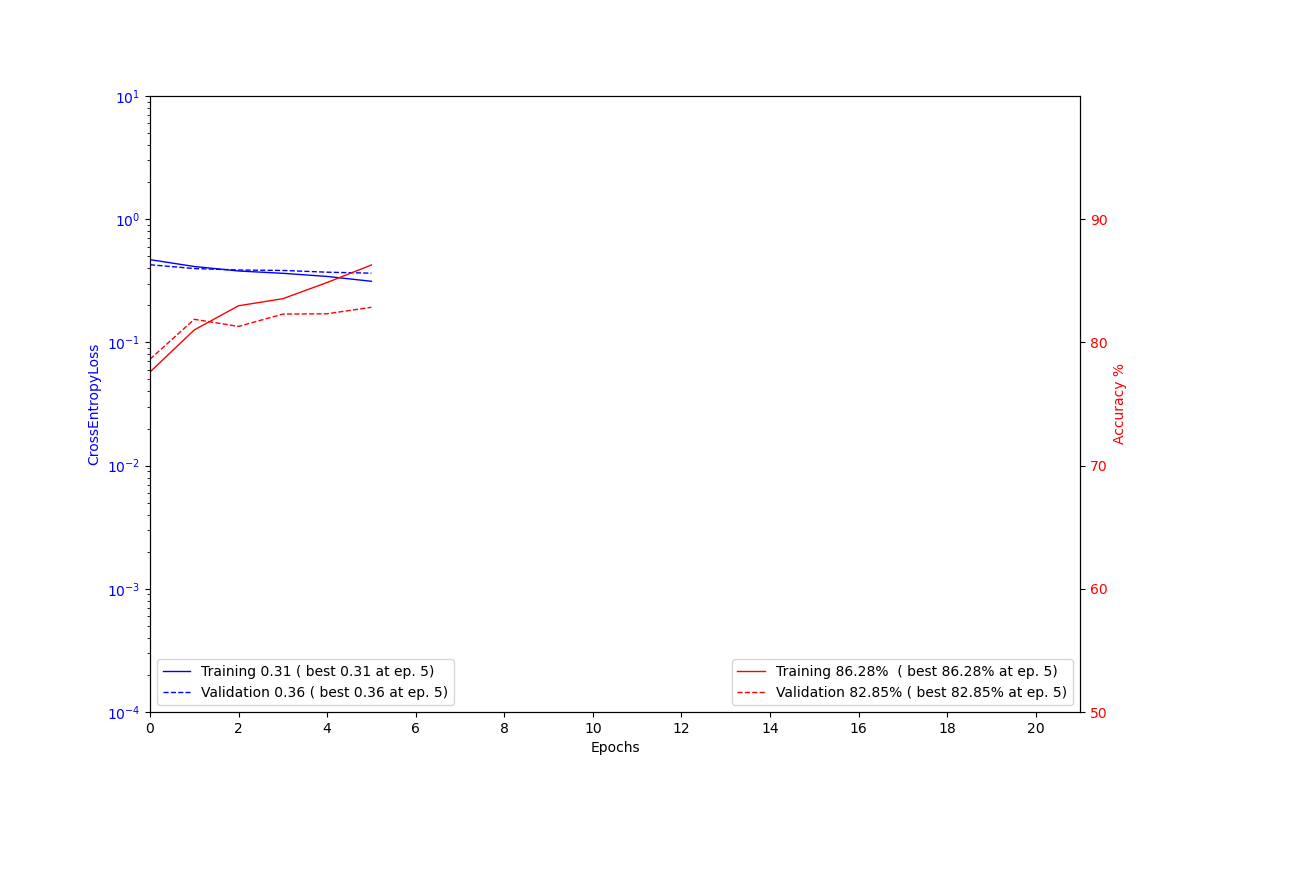


Epoch 2/20
----------
...TIME: 116.12 seconds
...train loss: 0.41 (best 0.41 at epoch 1)
...validation loss: 0.40 (best 0.40 at epoch 0)
...training accuracy: 81.01 (best 81.01 at epoch 1)
...validation accuracy: 81.88 (best 81.88 at epoch 1)

Epoch 3/20
----------
...TIME: 116.78 seconds
...train loss: 0.38 (best 0.38 at epoch 2)
...validation loss: 0.39 (best 0.39 at epoch 0)
...training accuracy: 82.97 (best 82.97 at epoch 2)
...validation accuracy: 81.30 (best 81.88 at epoch 1)

Epoch 4/20
----------
...TIME: 116.50 seconds
...train loss: 0.36 (best 0.36 at epoch 3)
...validation loss: 0.38 (best 0.38 at epoch 0)
...training accuracy: 83.55 (best 83.55 at epoch 3)
...validation accuracy: 82.30 (best 82.30 at epoch 3)

Epoch 5/20
----------
...TIME: 116.76 seconds
...train loss: 0.34 (best 0.34 at epoch 4)
...validation loss: 0.37 (best 0.37 at epoch 0)
...training accuracy: 84.86 (best 84.86 at epoch 4)
...validation accuracy: 82.32 (best 82.32 at epoch 4)

Epoch 6/20
----------
.

In [ ]:
model = train_model(net, val_labels, dataloaders, criterion, optimizer, scheduler, 'try_model_mobilenetv3.pt', num_epochs=epochs, load_trained=False)

In [ ]:
save(model, RESULTS_DIR+'/try_model_mobilenetv3_final.pt')

## **Model Testing**